# Image Generation with Deeplearning 

## Introduction
This is the notebook to be delivered as conclusion of week 5 on CU Boulder couse on coursera Introduction to Deep Learning).

This project was based on https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

I'll use CycleGAN with Tensorflow and Keras to tranform the photos on the datase to Monet paintings style.

I'll try to use the TPU available on Kaggle to accelerate the process.

## Data analysis and Loading

In [1]:
#basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Others
from kaggle_datasets import KaggleDatasets
import PIL
import shutil

#to dynamically figure out settings at runtime 
AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Tensorflow version: ",tf.__version__)

# TPU on Kaggle is not working... having errors everytime I tried to use it... going back to GPUP100
use_tpu=1
try:
    if use_tpu:
        print("try to use TPU")
        # Attempt to connect to a TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU")    
except:
    print("Error to use TPU")
    use_tpu=0

if use_tpu==0:    
    strategy = tf.distribute.get_strategy()
    print('TPU not found')

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

E0000 00:00:1756399614.298209      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


Tensorflow version:  2.18.0
try to use TPU
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1756399632.234418      10 service.cc:148] XLA service 0x590ecc9a05c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756399632.234466      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1756399632.234470      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1756399632.234473      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1756399632.234476      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1756399632.234479      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1756399632.234481      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1756399632.234484      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1756399632.234486      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

Let's load the data

In [2]:
MONET_FILENAMES = tf.io.gfile.glob(str('../input/gan-getting-started/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str('../input/gan-getting-started/photo_tfrec/*.tfrec'))
#check if was loaded correctly
print(f"Total filenames: Monet: {len(MONET_FILENAMES)} Photo: {len(PHOTO_FILENAMES)}")

Total filenames: Monet: 5 Photo: 20


Let's load the datasets

In [3]:
# we will need a function to return the tfrecord:
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    
    #scale images to [-1,1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    
    # images are sized to 256x256
    image = tf.reshape(image, [*[256, 256], 3]) 
    return image

#to extract images from files
def load_dataset(filenames, labeled=True, ordered=False):
    return tf.data.TFRecordDataset(filenames).map(read_tfrecord, num_parallel_calls=AUTOTUNE)

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)


Visualize an example and a monet example

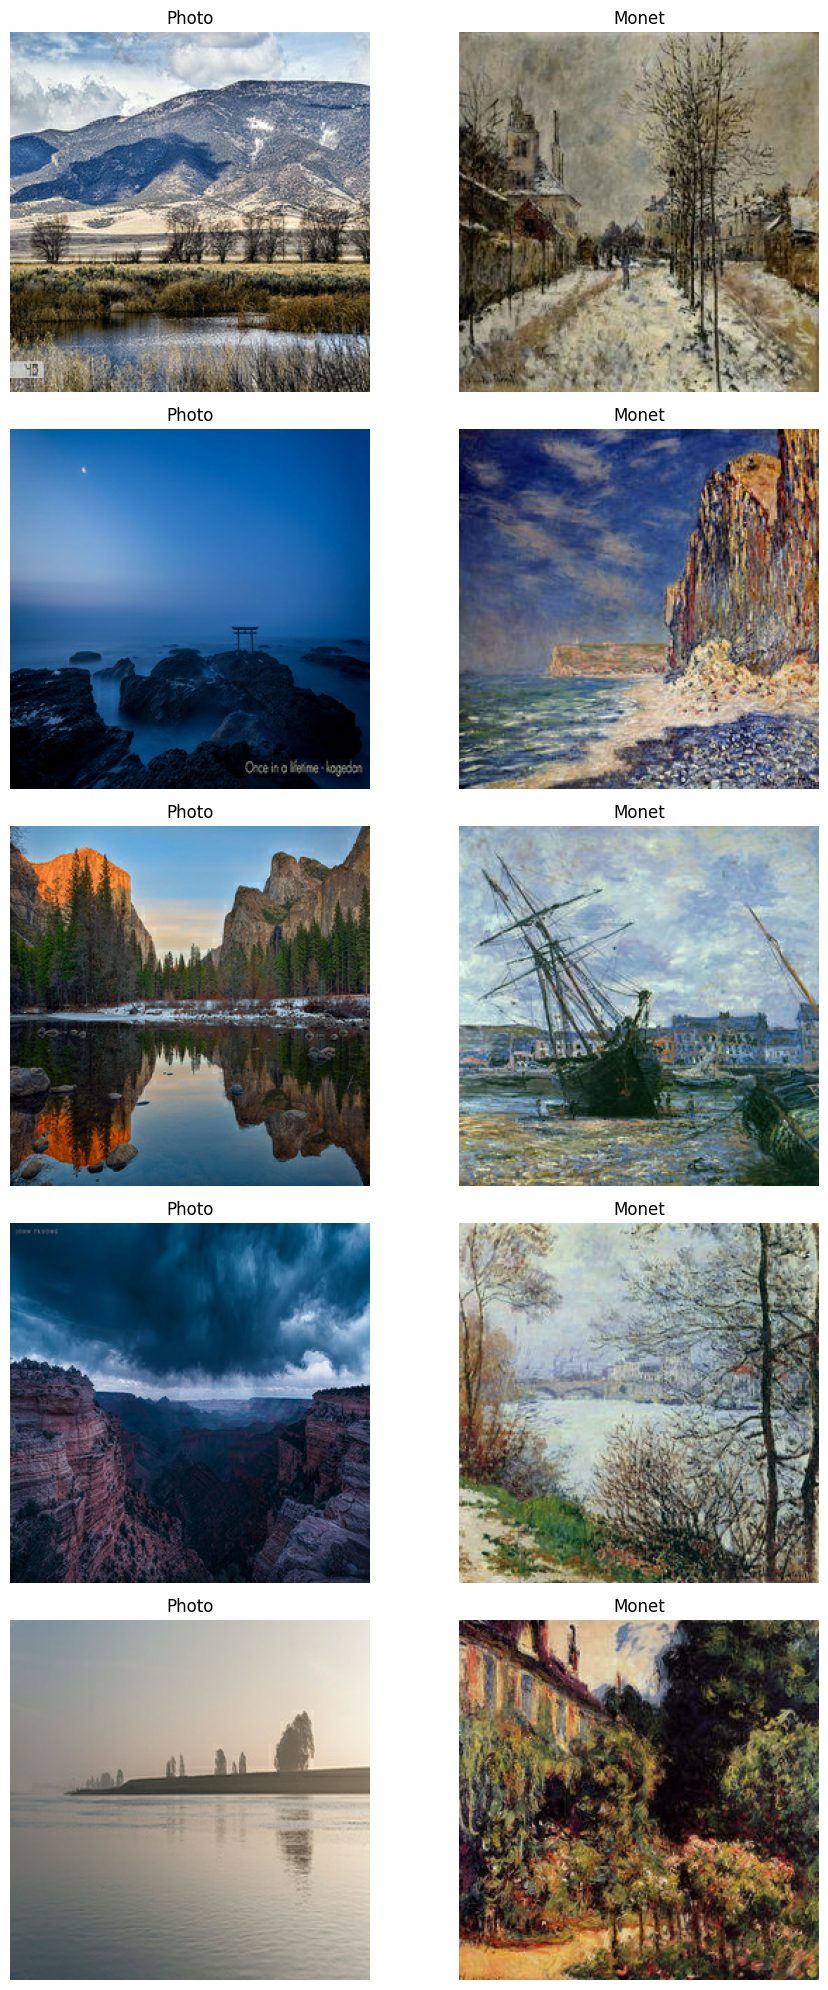

In [4]:
plt.figure(figsize=(10, 20))

# Get 5 image examples from each dataset
photo_examples = list(photo_ds.take(5))
monet_examples = list(monet_ds.take(5))

# Loop through and display the images
for i in range(5):
    # Display the original photo
    plt.subplot(5, 2, 2*i + 1)
    plt.title('Photo')
    plt.imshow(photo_examples[i][0] * 0.5 + 0.5)
    plt.axis('off')

    # Display the Monet-style painting
    plt.subplot(5, 2, 2*i + 2)
    plt.title('Monet')
    plt.imshow(monet_examples[i][0] * 0.5 + 0.5)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Building the model

The UNET architecture will be used and to create the model we will need pieces:
* Generator
* Discriminator
* and then, the CucleGAN model

For the generador, we need down and upsample to reduce and increase the dimensions of the image. We will use stride=2 to filter every other pixel, reducing by half height ans weight. 

In [5]:
#to be used on both fncitons 
initializer = tf.random_normal_initializer(0., 0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def downsample(filters, size, instancenorm=True):
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if instancenorm:
        result.add(layers.GroupNormalization(groups=filters, axis=-1,gamma_initializer=gamma_init))
        
    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, dropout=False):
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    
    result.add(layers.GroupNormalization(groups=filters, axis=-1,gamma_initializer=gamma_init))
    
    if dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Generator
The generator will downsample the input images and then, upsample it. To avoid VGP (vanish gradient problem) we skip connections and concatenates the output to multiple layers instead of only one.

In [6]:
def generator_unet():
    # 256x256 pixel and RGB
    image_input = layers.Input(shape=[256, 256, 3])

    #downsampling
    # Reduce the size, extract features.
    encoder_stack = [
        downsample(64, 4, instancenorm=False),  # Output: (batch_size, 128, 128, 64)
        downsample(128, 4),                           # Output: (batch_size, 64, 64, 128)
        downsample(256, 4),                           # Output: (batch_size, 32, 32, 256)
        downsample(512, 4),                           # Output: (batch_size, 16, 16, 512)
        downsample(512, 4),                           # Output: (batch_size, 8, 8, 512)
        downsample(512, 4),                           # Output: (batch_size, 4, 4, 512)
        downsample(512, 4),                           # Output: (batch_size, 2, 2, 512)
        downsample(512, 4),                           # Bottleneck: (batch_size, 1, 1, 512)
    ]

    #upsampling
    decoder_stack = [
        upsample(512, 4, dropout=True),  # Output: (batch_size, 2, 2, 1024)
        upsample(512, 4, dropout=True),  # Output: (batch_size, 4, 4, 1024)
        upsample(512, 4, dropout=True),  # Output: (batch_size, 8, 8, 1024)
        upsample(512, 4),                      # Output: (batch_size, 16, 16, 1024)
        upsample(256, 4),                      # Output: (batch_size, 32, 32, 512)
        upsample(128, 4),                      # Output: (batch_size, 64, 64, 256)
        upsample(64, 4),                       # Output: (batch_size, 128, 128, 128)
    ]
    
    final_layer = layers.Conv2DTranspose(3, 4, 
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    #Conecting layers
    x = image_input
    skip_connections = []
    
    for block in encoder_stack:
        x = block(x)
        skip_connections.append(x)

    # Reverse the list of skip connections, and drop from the bottleneck.
    skip_connections = reversed(skip_connections[:-1])

    # Decoder
    for up_block, skip in zip(decoder_stack, skip_connections):
        x = up_block(x)
        x = layers.Concatenate()([x, skip])


    return keras.Model(inputs=image_input, outputs=final_layer(x))

### Discriminator

It will get an image and check if is real. Outputing a small image. Higher pixel indicates a real classification, and lower a wrong classification

In [7]:
def discriminator():
    # Define the input layer
    input_image = layers.Input(shape=[256, 256, 3], name='input_image')
    x = input_image

    # Downsampling path
    x = downsample(64, 4, instancenorm=False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)

    # Convolutional feature extraction
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1,
                      kernel_initializer=initializer,
                      use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(x)

    x = layers.LeakyReLU()(x)

    # Produce the final output patch
    x = layers.ZeroPadding2D()(x)
    output_patch = layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(x)

    return keras.Model(inputs=input_image, outputs=output_patch)

concluding Generator and discriminator

In [8]:
with strategy.scope():
    #from photos to monet
    monet_generator = generator_unet()
    #from monet to photos
    photo_generator = generator_unet()

    #check if is real Monet
    monet_discriminator = discriminator()
    #check if is real photos
    photo_discriminator = discriminator()

I0000 00:00:1756399639.047294      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Building the model

The model learns by doing a round trip: It turns a regular photo into a Monet painting, and then immediately tries to turn it back into the original photo. The idea is to garantee the photo looks the same as the starting one. 

If it doesn't, the model knows it messed up and learns.

In [9]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()

        self.gen_M = monet_generator
        self.gen_P = photo_generator
        self.disc_M = monet_discriminator
        self.disc_P = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def call(self, inputs):
        return self.gen_M(inputs)

    def compile(self, gen_M_optimizer, gen_P_optimizer, disc_M_optimizer, disc_P_optimizer, gen_loss, disc_loss, cycle_loss, identity_loss):
        super(CycleGan, self).compile()

        # optimizers
        self.gen_M_opt = gen_M_optimizer
        self.gen_P_opt = gen_P_optimizer
        self.disc_M_opt = disc_M_optimizer
        self.disc_P_opt = disc_P_optimizer

        # loss functions
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss

    def train_step(self, data):
        real_monet, real_photo = data

        with tf.GradientTape(persistent=True) as tape:
            # forward cycle: Photo -> Monet -> Photo
            fake_monet = self.gen_M(real_photo, training=True)
            cycled_photo = self.gen_P(fake_monet, training=True)

            # forward cycle: Monet -> Photo -> Monet
            fake_photo = self.gen_P(real_monet, training=True)
            cycled_monet = self.gen_M(fake_photo, training=True)

            # identity mapping
            identity_monet = self.gen_M(real_monet, training=True)
            identity_photo = self.gen_P(real_photo, training=True)

            # discriminator outputs
            disc_real_monet = self.disc_M(real_monet, training=True)
            disc_fake_monet = self.disc_M(fake_monet, training=True)

            disc_real_photo = self.disc_P(real_photo, training=True)
            disc_fake_photo = self.disc_P(fake_photo, training=True)

            # ---- calculate all the losses ----

            # generator loss
            gen_M_loss = self.gen_loss(disc_fake_monet)
            gen_P_loss = self.gen_loss(disc_fake_photo)

            # cycle loss
            total_cycle_loss = self.cycle_loss(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss(real_photo, cycled_photo, self.lambda_cycle)

            # identity loss
            id_loss_M = self.identity_loss(real_monet, identity_monet, self.lambda_cycle)
            id_loss_P = self.identity_loss(real_photo, identity_photo, self.lambda_cycle)

            # total generator loss
            total_gen_M_loss = gen_M_loss + total_cycle_loss + id_loss_M
            total_gen_P_loss = gen_P_loss + total_cycle_loss + id_loss_P

            # discriminator loss
            disc_M_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
            disc_P_loss = self.disc_loss(disc_real_photo, disc_fake_photo)

        # get gradients
        grads_gen_M = tape.gradient(total_gen_M_loss, self.gen_M.trainable_variables)
        grads_gen_P = tape.gradient(total_gen_P_loss, self.gen_P.trainable_variables)
        grads_disc_M = tape.gradient(disc_M_loss, self.disc_M.trainable_variables)
        grads_disc_P = tape.gradient(disc_P_loss, self.disc_P.trainable_variables)

        # update weights
        self.gen_M_opt.apply_gradients(zip(grads_gen_M, self.gen_M.trainable_variables))
        self.gen_P_opt.apply_gradients(zip(grads_gen_P, self.gen_P.trainable_variables))
        self.disc_M_opt.apply_gradients(zip(grads_disc_M, self.disc_M.trainable_variables))
        self.disc_P_opt.apply_gradients(zip(grads_disc_P, self.disc_P.trainable_variables))

        return {
            "gen_M_loss": total_gen_M_loss,
            "gen_P_loss": total_gen_P_loss,
            "disc_M_loss": disc_M_loss,
            "disc_P_loss": disc_P_loss,
        }

#### Loss funcions
**Discriminator loss**: The model learns to tell the difference between real Monets and the fakes.

**Generator loss**: The model tries to fool the critic into thinking its fakes are real.

**Cycle loss**:  It makes sure that if you turn a photo into a Monet and back into a photo, you get something that looks like your original photo.

**Identity loss**: If you give the Monet generator a real Monet painting, it shouldn't change it.

In [10]:
with strategy.scope():
    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
    mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

    def discriminator_loss(real, generated):
        # Calculate how much the discriminator can distinguish between real and fakes.
        real_loss = bce_loss_fn(tf.ones_like(real), real)
        generated_loss = bce_loss_fn(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        # Calculates as much the generator was able to trick the discriminator.
        return bce_loss_fn(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        # Use the mae for loss calculation.
        loss1 = mae_loss_fn(real_image, cycled_image)
        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        # Use loss
        loss = mae_loss_fn(real_image, same_image)
        return LAMBDA * 0.5 * loss

## Train the model

We need to compile and then use the fit to train

In [11]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        gen_M_optimizer = monet_generator_optimizer,
        gen_P_optimizer = photo_generator_optimizer,
        disc_M_optimizer = monet_discriminator_optimizer,
        disc_P_optimizer = photo_discriminator_optimizer,
        gen_loss = generator_loss,
        disc_loss = discriminator_loss,
        cycle_loss = calc_cycle_loss,
        identity_loss = identity_loss
    )

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


I0000 00:00:1756399726.345800      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13889901171005130794
I0000 00:00:1756399735.211763     878 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18244617623761708265), session_name()
I0000 00:00:1756399812.652429     878 tpu_compile_op_common.cc:245] Compilation of 18244617623761708265 with session name  took 1m17.440617929s and succeeded
I0000 00:00:1756399812.867245     878 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18244617623761708265), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_13889901171005130794", property.function_library_fingerprint = 13469869985634401131, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.w

    300/Unknown 204s 157ms/step - disc_M_loss: 0.6785 - disc_P_loss: 0.6410 - gen_M_loss: 1.2914 - gen_P_loss: 1.3646

/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 204s 158ms/step - disc_M_loss: 0.6786 - disc_P_loss: 0.6412 - gen_M_loss: 1.2909 - gen_P_loss: 1.3635
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - disc_M_loss: 0.6875 - disc_P_loss: 0.6686 - gen_M_loss: 1.1184 - gen_P_loss: 1.1724
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - disc_M_loss: 0.6848 - disc_P_loss: 0.6792 - gen_M_loss: 1.1171 - gen_P_loss: 1.1486
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - disc_M_loss: 0.6851 - disc_P_loss: 0.6859 - gen_M_loss: 1.1127 - gen_P_loss: 1.1287
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - disc_M_loss: 0.6852 - disc_P_loss: 0.6857 - gen_M_loss: 1.1071 - gen_P_loss: 1.1169
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - disc_M_loss: 0.6837 - disc_P_loss: 0.6881 - gen_M_loss: 1.1027 - gen_P_loss: 1.1059
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - disc_M_loss: 0.6841 - disc_P_loss: 0.6863 - gen_M_loss: 1.0899 - gen_P_loss: 1.0925
Epoch 8/25
300/300 ━━━━

## Testing our model

let's visualize our photos

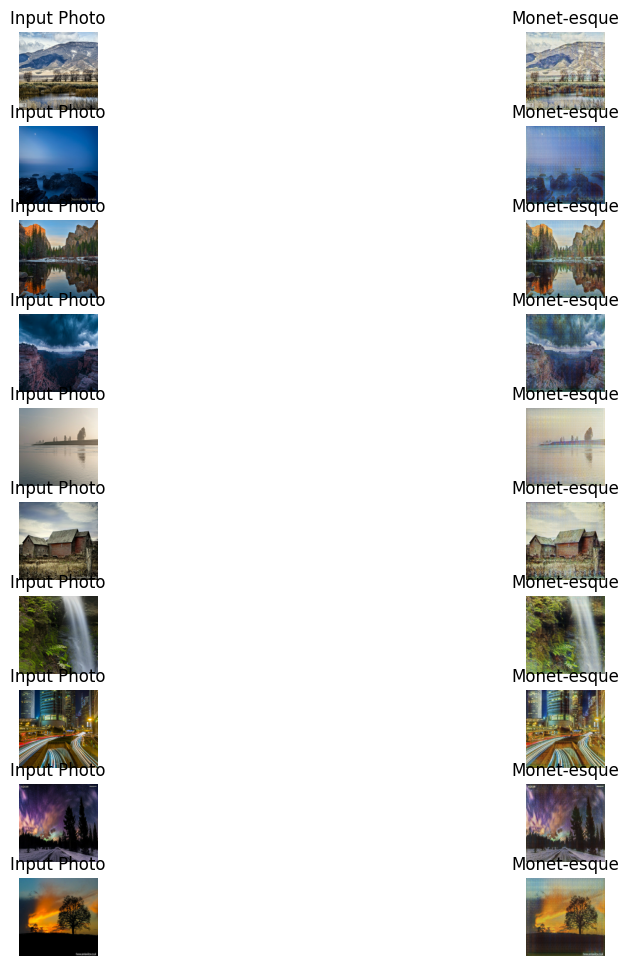

In [12]:
_, ax = plt.subplots(10, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(10)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Submission

let's do the export, zip and submission


In [13]:
! mkdir ../images
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

#zip and upload
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

### Conclusion

A CycleGAN is a powerful type of AI that learns how to translate images without needing paired examples.

It works training two models to do a "round trip" (one model changes the photo to a Monet, and the other changes it back). And the model learns by making sure the final photo looks like the original. 

The Keras implementation in this notebook makes this complex process easier by bundling all the logic into a custom CycleGan model, allowing to train everything with a simple .fit() command.